In [144]:
import gymnasium as gym 
from gymnasium import Env
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import tensorflow as tf
import datetime

# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)

class missile_interception(Env):
    def __init__(self):
        self.action_space = gym.spaces.Discrete(3)
        low = np.array([-1, -1, -1, -1, -1, -1, -1, -1, -2, -2])
        high = np.array([1, 1, 1, 1, 1, 1, 1, 1, 2, 2])

        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=np.float32)
        self.radius = 0.02

        self.episode_count = 0

        self.defense_positions = []
        self.attack_positions = []

    def reset(self, seed=None):
        self.defense_positions = []
        self.attack_positions = []
        self.reward = 0
        self.current_step = 0
        self.done = False
        self.create_defense()
        self.create_attack(self.defense)
        self.calc_angle(self.defense, self.attack)
        self.initial_missile_angle()
        self.missile_distance_to_attack()
        # self.graph(self.defense, self.attack)
        self.get_state()

        return self.state, {}

    def create_defense(self):
        x = random.uniform(-0.45, 0.45)
        y = random.uniform(-0.45, 0.45)
        print("--//--//--//--//--//--//--//--//--//--//")
        print("X VAL", x)
        print("Y VAL", y)
        print("--//--//--//--//--//--//--//--//--//--//")
        self.defense = np.array([x, y])

    def create_attack(self, defense):
        x_side_left = random.uniform(-0.95, (defense[0] - 0.02) - 0.1)
        x_side_right = random.uniform((defense[0] + 0.02) + 0.1, 0.95)
        y_below = random.uniform((defense[1] - 0.02) - 0.1, -0.95)
        y_above = random.uniform((defense[1] + 0.02) + 0.1, 0.95)
        x_inclusive = random.uniform(-0.95, 0.95)
        y_inclusive = random.uniform(-0.95, 0.95)
        y_below_x_inclusive = np.array([x_inclusive, y_below])
        y_above_x_inclusive = np.array([x_inclusive, y_above])
        x_left_y_inclusive = np.array([x_side_left, y_inclusive])
        x_right_y_inclusive = np.array([x_side_right, y_inclusive])

        self.attack = random.choice([y_below_x_inclusive, y_above_x_inclusive, x_left_y_inclusive, x_right_y_inclusive])

    def calc_angle(self, defense, attack):

        # create an adjacent point of the form (attack_x, defense_y)
        adjacent_point = np.array([attack[0], defense[1]])

        # calculate the distance between the adjacent point and the defense, attack points
        adj_point_defense_len = abs(defense[0] - adjacent_point[0]) 
        adj_point_attack_len = abs(attack[1] - adjacent_point[1])

        # calculate the angle, using soh cah toa, where adj_point_defense_len is the adjacent side and adj_point_attack_len is the opposite side
        self.theta = np.arctan(adj_point_attack_len / adj_point_defense_len)
        
        if attack[0] > defense[0]:
            if attack[1] > defense[1]:
                self.theta = self.theta # 1st quadrant
            else: 
                self.theta = (2*math.pi) - self.theta # 360 - theta
        else:
            if attack[1] > defense[1]:
                self.theta = math.pi - self.theta # 180 - theta
            else:
                self.theta = math.pi + self.theta # 180 + theta
            
        return self.theta
    
    def initial_missile_angle(self):
        if self.theta < math.pi:
            self.missile_angle = np.random.uniform(0, math.pi)
        else:
            self.missile_angle = np.random.uniform(math.pi, 2*math.pi)

    def calculate_distance(self, point1, point2):
        return math.hypot(point1[0] - point2[0], point1[1] - point2[1])
    
    def missile_distance_to_attack(self):
        self.distance = (self.calculate_distance(self.defense, self.attack) - (2 * self.radius))

    def missile_nav_angle(self, action):
        if action == 0:
            self.missile_angle = self.missile_angle 
        elif action == 1:
            self.missile_angle += 0.174532925
        elif action == 2:
            self.missile_angle -= 0.174532925

    def missle_coord_calc(self):
        self.defense[0] += (0.02 * math.cos(self.theta)) # gotta test this
        self.defense[1] += (0.02 * math.sin(self.theta))

        self.defense_positions.append(self.defense.copy())
        self.attack_positions.append(self.attack.copy())

    def calculate_reward(self):
        # check if out of bounds
        if self.defense[0] < -1 or self.defense[0] > 1 or self.defense[1] < -1 or self.defense[1] > 1:
            self.reward -= 100
            self.done = True
        
        self.missile_distance_to_attack()
        if self.distance < 0:
            self.reward += 100
            self.done = True
        else:
            # time penalty
            self.reward -= 0.001
            self.reward -= self.distance

            # angle penalty
            self.angle_diff = abs(self.theta - self.missile_angle)
            self.angle_diff = min(self.angle_diff, 2*math.pi - self.angle_diff)
            if self.angle_diff < 0.05:
                self.reward += 0.1
            else:
                self.reward -= (0.1 * self.angle_diff)
        
        self.missile_distance_to_attack()
        self.reward -= self.distance

    def angle_conversion(self):
        self.sin_theta, self.sin_missile_angle = np.sin(self.theta), np.sin(self.missile_angle)
        self.cos_theta, self.cos_missile_angle = np.cos(self.theta), np.cos(self.missile_angle)

        self.delta_sin = self.sin_theta - self.sin_missile_angle
        self.delta_cos = self.cos_theta - self.cos_missile_angle

    def get_state(self):
        self.angle_conversion()
        self.state = np.array([self.attack[0], self.attack[1], self.defense[0], self.defense[1], self.sin_theta, self.cos_theta, self.sin_missile_angle, self.cos_missile_angle, self.delta_sin, self.delta_cos])

    def get_state_dict(self):
        return {"reward": self.reward, "attack_x": self.attack[0], "attack_y": self.attack[1], "defense_x": self.defense[0], "defense_y": self.defense[1], "theta": self.theta, "missile_angle": self.missile_angle, "self.sin_theta": self.sin_theta, "self.cos_theta": self.cos_theta, "self.sin_missile_angle": self.sin_missile_angle, "self.cos_missile_angle": self.cos_missile_angle, "delta_sin": self.delta_sin, "delta_cos": self.delta_cos, "distance": self.distance}
                 
    def step(self, action):
        print("--//--//--//--//--//--//--//--//--//--//")
        print("BEFORE MISSILE NAV ANGLE CALC --- BEFORE STEP")
        print("Attack position: ", self.attack)
        print("Defense position: ", self.defense)
        print("--//--//--//--//--//--//--//--//--//--//")
        self.missile_nav_angle(action)
        print("--//--//--//--//--//--//--//--//--//--//")
        print("BEFORE MISSILE COORD CALC")
        print("Attack position: ", self.attack)
        print("Defense position: ", self.defense)
        print("--//--//--//--//--//--//--//--//--//--//")
        self.missle_coord_calc()
        print("--//--//--//--//--//--//--//--//--//--//")
        print("AFTER MISSILE COORD CALC")
        print("Attack position: ", self.attack)
        print("Defense position: ", self.defense)
        print("--//--//--//--//--//--//--//--//--//--//")
        self.calculate_reward()
        self.current_step += 1
        self.get_state()

        print("--//--//--//--//--//--//--//--//--//--//")
        print("Attack position: ", self.attack)
        print("Defense position: ", self.defense)
        print("--//--//--//--//--//--//--//--//--//--//")

        self.graph(self.defense, self.attack)

        return self.state, self.reward, self.done, False, {}

    def graph(self, defense, attack):
        fig, ax = plt.subplots()
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)

        plt.axhline(0, color='black', linewidth=0.5)
        plt.axvline(0, color='black', linewidth=0.5)
        plt.grid(True)

        # Plot trails
        if self.defense_positions:
            defense_xs, defense_ys = zip(*self.defense_positions)
            ax.plot(defense_xs, defense_ys, 'b-')  # Blue line for defense

        if self.attack_positions:
            attack_xs, attack_ys = zip(*self.attack_positions)
            ax.plot(attack_xs, attack_ys, 'r-')  # Red line for attack

        # Plot current positions
        plt.scatter(defense[0], defense[1], color='black')
        plt.scatter(attack[0], attack[1], color='red')

        ax.set_aspect('equal')
        plt.show()


    # def capture_episode(self):
    #     # This function will run every x amount of episodes, the purpose is to capture the data of the episode and store it in a list
    #     self.episode.append(self.get_state_dict())

    # def setup_animation(self):
        
    #     self.fig, self.ax = plt.subplots()
    #     self.ax.set_xlim(-1, 1)
    #     self.ax.set_ylim(-1, 1)
    #     self.point, = self.ax.plot([], [], 'bo')
    #     plt.show(block=False)

    # def update_animation(self):
    #     self.point.set_data(self.defense[0], self.defense[1])
    #     plt.draw()
    #     plt.pause(0.01)

--//--//--//--//--//--//--//--//--//--//
X VAL -0.37621493505461207
Y VAL 0.14163584802527024
--//--//--//--//--//--//--//--//--//--//
----------------------------------------------------------
STARTING ENV
----------------------------------------------------------
Initial State: {'reward': 0, 'attack_x': -0.3530506606884054, 'attack_y': 0.7226512007031529, 'defense_x': -0.37621493505461207, 'defense_y': 0.14163584802527024, 'theta': 1.5309488207007917, 'missile_angle': 3.0470616661964836, 'self.sin_theta': 0.9992061931728234, 'self.cos_theta': 0.03983696179522534, 'self.sin_missile_angle': 0.09439026044012766, 'self.cos_missile_angle': -0.9955352724710687, 'delta_sin': 0.9048159327326958, 'delta_cos': 1.035372234266294, 'distance': 0.5414769330371733}
............................................
STATE BEFORE ACTION: {'reward': 0, 'attack_x': -0.3530506606884054, 'attack_y': 0.7226512007031529, 'defense_x': -0.37621493505461207, 'defense_y': 0.14163584802527024, 'theta': 1.530948820700

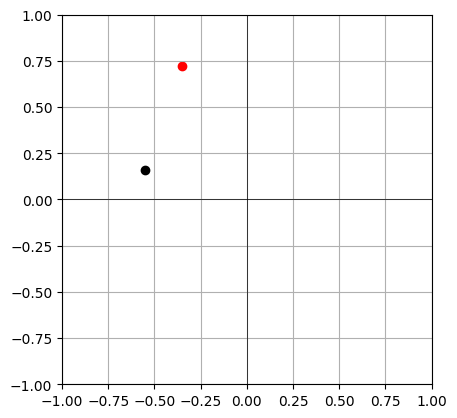

Step 1:
Action Taken: Left
Current State: {'reward': -1.261772048962102, 'attack_x': -0.3530506606884054, 'attack_y': 0.7226512007031529, 'defense_x': -0.5499511208187076, 'defense_y': 0.1616199718887267, 'theta': 1.5309488207007917, 'missile_angle': 3.0470616661964836, 'self.sin_theta': 0.9992061931728234, 'self.cos_theta': 0.03983696179522534, 'self.sin_missile_angle': 0.09439026044012766, 'self.cos_missile_angle': -0.9955352724710687, 'delta_sin': 0.9048159327326958, 'delta_cos': 1.035372234266294, 'distance': 0.5545803822062664}
Reward Received: -1.261772048962102
Done: False
-------------------------------------------------------
............................................
STATE BEFORE ACTION: {'reward': -1.261772048962102, 'attack_x': -0.3530506606884054, 'attack_y': 0.7226512007031529, 'defense_x': -0.5499511208187076, 'defense_y': 0.1616199718887267, 'theta': 1.5309488207007917, 'missile_angle': 3.0470616661964836, 'self.sin_theta': 0.9992061931728234, 'self.cos_theta': 0.0398

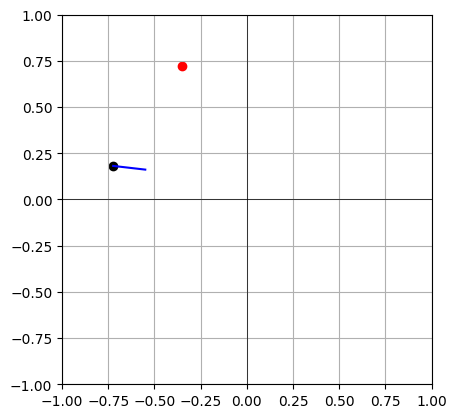

Step 2:
Action Taken: Left
Current State: {'reward': -2.646028854307095, 'attack_x': -0.3530506606884054, 'attack_y': 0.7226512007031529, 'defense_x': -0.7236873065828031, 'defense_y': 0.18160409575218317, 'theta': 1.5309488207007917, 'missile_angle': 3.0470616661964836, 'self.sin_theta': 0.9992061931728234, 'self.cos_theta': 0.03983696179522534, 'self.sin_missile_angle': 0.09439026044012766, 'self.cos_missile_angle': -0.9955352724710687, 'delta_sin': 0.9048159327326958, 'delta_cos': 1.035372234266294, 'distance': 0.615822760397712}
Reward Received: -2.646028854307095
Done: False
-------------------------------------------------------
............................................
STATE BEFORE ACTION: {'reward': -2.646028854307095, 'attack_x': -0.3530506606884054, 'attack_y': 0.7226512007031529, 'defense_x': -0.7236873065828031, 'defense_y': 0.18160409575218317, 'theta': 1.5309488207007917, 'missile_angle': 3.0470616661964836, 'self.sin_theta': 0.9992061931728234, 'self.cos_theta': 0.039

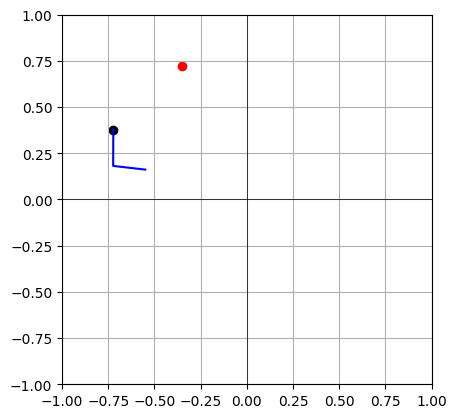

Step 3:
Action Taken: Right
Current State: {'reward': -3.732276437198783, 'attack_x': -0.3530506606884054, 'attack_y': 0.7226512007031529, 'defense_x': -0.7228905673468986, 'defense_y': 0.37612114461563967, 'theta': 1.5309488207007917, 'missile_angle': 3.0470616661964836, 'self.sin_theta': 0.9992061931728234, 'self.cos_theta': 0.03983696179522534, 'self.sin_missile_angle': 0.09439026044012766, 'self.cos_missile_angle': -0.9955352724710687, 'delta_sin': 0.9048159327326958, 'delta_cos': 1.035372234266294, 'distance': 0.4668181491710593}
Reward Received: -3.732276437198783
Done: False
-------------------------------------------------------
............................................
STATE BEFORE ACTION: {'reward': -3.732276437198783, 'attack_x': -0.3530506606884054, 'attack_y': 0.7226512007031529, 'defense_x': -0.7228905673468986, 'defense_y': 0.37612114461563967, 'theta': 1.5309488207007917, 'missile_angle': 3.0470616661964836, 'self.sin_theta': 0.9992061931728234, 'self.cos_theta': 0.0

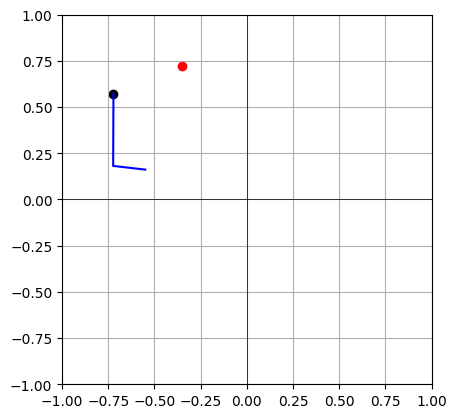

Step 4:
Action Taken: Right
Current State: {'reward': -4.603137842416299, 'attack_x': -0.3530506606884054, 'attack_y': 0.7226512007031529, 'defense_x': -0.7220938281109941, 'defense_y': 0.5706381934790962, 'theta': 1.5309488207007917, 'missile_angle': 3.0470616661964836, 'self.sin_theta': 0.9992061931728234, 'self.cos_theta': 0.03983696179522534, 'self.sin_missile_angle': 0.09439026044012766, 'self.cos_missile_angle': -0.9955352724710687, 'delta_sin': 0.9048159327326958, 'delta_cos': 1.035372234266294, 'distance': 0.35912506033397346}
Reward Received: -4.603137842416299
Done: False
-------------------------------------------------------
............................................
STATE BEFORE ACTION: {'reward': -4.603137842416299, 'attack_x': -0.3530506606884054, 'attack_y': 0.7226512007031529, 'defense_x': -0.7220938281109941, 'defense_y': 0.5706381934790962, 'theta': 1.5309488207007917, 'missile_angle': 3.0470616661964836, 'self.sin_theta': 0.9992061931728234, 'self.cos_theta': 0.03

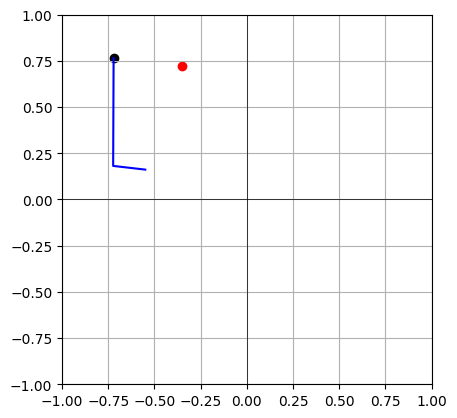

Step 5:
Action Taken: Right
Current State: {'reward': -5.417131687936747, 'attack_x': -0.3530506606884054, 'attack_y': 0.7226512007031529, 'defense_x': -0.7212970888750896, 'defense_y': 0.7651552423425526, 'theta': 1.5309488207007917, 'missile_angle': 3.0470616661964836, 'self.sin_theta': 0.9992061931728234, 'self.cos_theta': 0.03983696179522534, 'self.sin_missile_angle': 0.09439026044012766, 'self.cos_missile_angle': -0.9955352724710687, 'delta_sin': 0.9048159327326958, 'delta_cos': 1.035372234266294, 'distance': 0.3306912804854392}
Reward Received: -5.417131687936747
Done: False
-------------------------------------------------------
............................................
STATE BEFORE ACTION: {'reward': -5.417131687936747, 'attack_x': -0.3530506606884054, 'attack_y': 0.7226512007031529, 'defense_x': -0.7212970888750896, 'defense_y': 0.7651552423425526, 'theta': 1.5309488207007917, 'missile_angle': 3.0470616661964836, 'self.sin_theta': 0.9992061931728234, 'self.cos_theta': 0.039

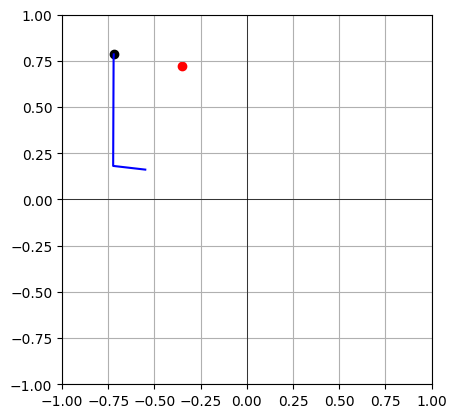

Step 6:
Action Taken: Stay
Current State: {'reward': -6.235193292059492, 'attack_x': -0.3530506606884054, 'attack_y': 0.7226512007031529, 'defense_x': -0.7205003496391851, 'defense_y': 0.7851393662060091, 'theta': 1.5309488207007917, 'missile_angle': 3.0470616661964836, 'self.sin_theta': 0.9992061931728234, 'self.cos_theta': 0.03983696179522534, 'self.sin_missile_angle': 0.09439026044012766, 'self.cos_missile_angle': -0.9955352724710687, 'delta_sin': 0.9048159327326958, 'delta_cos': 1.035372234266294, 'distance': 0.3327251597865874}
Reward Received: -6.235193292059492
Done: False
-------------------------------------------------------
............................................
STATE BEFORE ACTION: {'reward': -6.235193292059492, 'attack_x': -0.3530506606884054, 'attack_y': 0.7226512007031529, 'defense_x': -0.7205003496391851, 'defense_y': 0.7851393662060091, 'theta': 1.5309488207007917, 'missile_angle': 3.0470616661964836, 'self.sin_theta': 0.9992061931728234, 'self.cos_theta': 0.0398

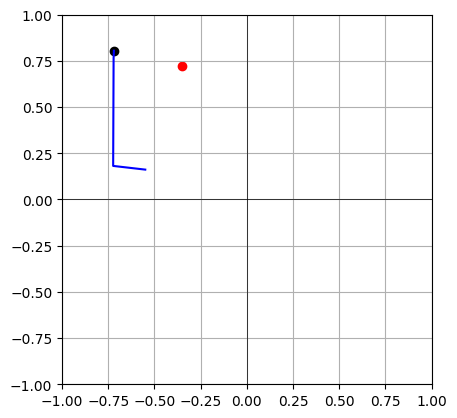

Step 7:
Action Taken: Stay
Current State: {'reward': -7.059432314383392, 'attack_x': -0.3530506606884054, 'attack_y': 0.7226512007031529, 'defense_x': -0.7197036104032806, 'defense_y': 0.8051234900694656, 'theta': 1.5309488207007917, 'missile_angle': 3.0470616661964836, 'self.sin_theta': 0.9992061931728234, 'self.cos_theta': 0.03983696179522534, 'self.sin_missile_angle': 0.09439026044012766, 'self.cos_missile_angle': -0.9955352724710687, 'delta_sin': 0.9048159327326958, 'delta_cos': 1.035372234266294, 'distance': 0.33581386888716547}
Reward Received: -7.059432314383392
Done: False
-------------------------------------------------------
............................................
STATE BEFORE ACTION: {'reward': -7.059432314383392, 'attack_x': -0.3530506606884054, 'attack_y': 0.7226512007031529, 'defense_x': -0.7197036104032806, 'defense_y': 0.8051234900694656, 'theta': 1.5309488207007917, 'missile_angle': 3.0470616661964836, 'self.sin_theta': 0.9992061931728234, 'self.cos_theta': 0.039

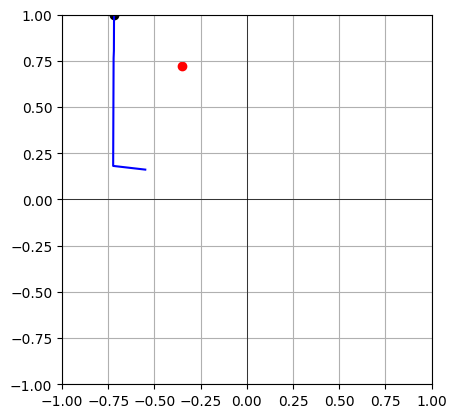

Step 8:
Action Taken: Right
Current State: {'reward': -8.049810149290945, 'attack_x': -0.3530506606884054, 'attack_y': 0.7226512007031529, 'defense_x': -0.7189068711673761, 'defense_y': 0.999640538932922, 'theta': 1.5309488207007917, 'missile_angle': 3.0470616661964836, 'self.sin_theta': 0.9992061931728234, 'self.cos_theta': 0.03983696179522534, 'self.sin_missile_angle': 0.09439026044012766, 'self.cos_missile_angle': -0.9955352724710687, 'delta_sin': 0.9048159327326958, 'delta_cos': 1.035372234266294, 'distance': 0.4188832751789918}
Reward Received: -8.049810149290945
Done: False
-------------------------------------------------------
............................................
STATE BEFORE ACTION: {'reward': -8.049810149290945, 'attack_x': -0.3530506606884054, 'attack_y': 0.7226512007031529, 'defense_x': -0.7189068711673761, 'defense_y': 0.999640538932922, 'theta': 1.5309488207007917, 'missile_angle': 3.0470616661964836, 'self.sin_theta': 0.9992061931728234, 'self.cos_theta': 0.03983

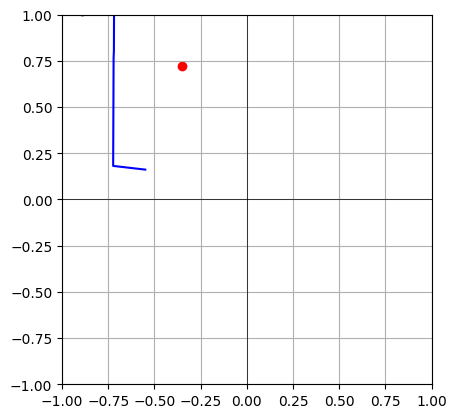

Step 9:
Action Taken: Left
Current State: {'reward': -109.35425452524694, 'attack_x': -0.3530506606884054, 'attack_y': 0.7226512007031529, 'defense_x': -0.8926430569314716, 'defense_y': 1.0196246627963785, 'theta': 1.5309488207007917, 'missile_angle': 3.0470616661964836, 'self.sin_theta': 0.9992061931728234, 'self.cos_theta': 0.03983696179522534, 'self.sin_missile_angle': 0.09439026044012766, 'self.cos_missile_angle': -0.9955352724710687, 'delta_sin': 0.9048159327326958, 'delta_cos': 1.035372234266294, 'distance': 0.5759165457032069}
Reward Received: -109.35425452524694
Done: True
-------------------------------------------------------


In [157]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import tensorflow as tf
import datetime

# Assuming missile_interception is already defined and imported

# Initialize and reset the environment
env = missile_interception()
initial_state, _ = env.reset()

print("----------------------------------------------------------")
print("STARTING ENV")
print("----------------------------------------------------------")
print("Initial State:", env.get_state_dict())

# Generate a sequence of random actions
num_steps = 20
actions = [random.choice([0, 1, 2]) for _ in range(num_steps)]

# Simulate the run
for i, action in enumerate(actions):
    print("............................................")
    print("STATE BEFORE ACTION:", env.get_state_dict())
    print("............................................")

    state, reward, done, truncated, _ = env.step(action)
    print(f"Step {i+1}:")
    print("Action Taken:", ["Stay", "Right", "Left"][action])
    print("Current State:", env.get_state_dict())
    print("Reward Received:", reward)
    print("Done:", done)
    print("-------------------------------------------------------")

    if done:
        break  # Exit the loop if the episode ends


In [146]:
# import gymnasium as gym
# from stable_baselines3 import DQN, PPO
# from stable_baselines3.common.vec_env import DummyVecEnv

# # Wrap it in a dummy vectorized environment (needed for some stable-baselines3 algorithms)
# env = DummyVecEnv([lambda: missile_interception()])

# model = DQN("MlpPolicy", env, tensorboard_log="./ppo_line_system_tensorboard/", verbose=1)
# model.learn(total_timesteps=1000000)

# model.save("updated_missile_guidance")
# env.close()